# TNT Sticky Rouse: LAOS

## Objectives
- Fit TNT Sticky Rouse model to LAOS data
- Analyze mode-resolved nonlinear response
- Understand Deborah (De) and Weissenberg (Wi) numbers per mode
- Visualize Lissajous curves and harmonic content

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTStickyRouse

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_pnas_laos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_sticky_rouse_param_names,
    plot_sticky_rouse_effective_times,
    plot_mode_decomposition,
)

print("Setup complete. JAX devices:", jax.devices())

Setup complete. JAX devices: [CpuDevice(id=0)]


## Theory: Mode-Resolved LAOS

**Large Amplitude Oscillatory Shear:**

Applied strain: γ(t) = γ₀ sin(ωt)

Shear rate: γ̇(t) = γ₀ ω cos(ωt)

**Dimensionless Numbers (per mode):**
- **Deborah number**: De_k = ω τ_eff,k (oscillation frequency vs relaxation)
- **Weissenberg number**: Wi_k = γ₀ ω τ_eff,k (maximum shear rate vs relaxation)

**Mode-Resolved Nonlinearity:**
- Mode k enters nonlinear regime when Wi_k > 1
- Different modes have different τ_eff,k → sequential nonlinearity onset
- Sticker-dominated modes (τ_eff = τ_s) all have same Wi → collective nonlinearity
- Rouse modes (τ_eff = τ_R,k) have individual nonlinear thresholds

**Observable Signatures:**
- **Lissajous curves**: Stress-strain (elastic) and stress-strain rate (viscous)
- **Harmonics**: Fourier decomposition reveals nonlinearity strength
- **Mode separation**: Fast modes dominate at high ω, slow modes at low ω

## Load Data

Data shape: 200 points
Time range: 5.27e-03 - 6.60e+01 s
Frequency: ω = 1.0 rad/s
Strain amplitude: γ₀ = 0.5120
Max shear rate: γ̇_max = γ₀ω = 0.5120 s^-1
Stress range: -1.73e+01 - 2.04e+01 Pa


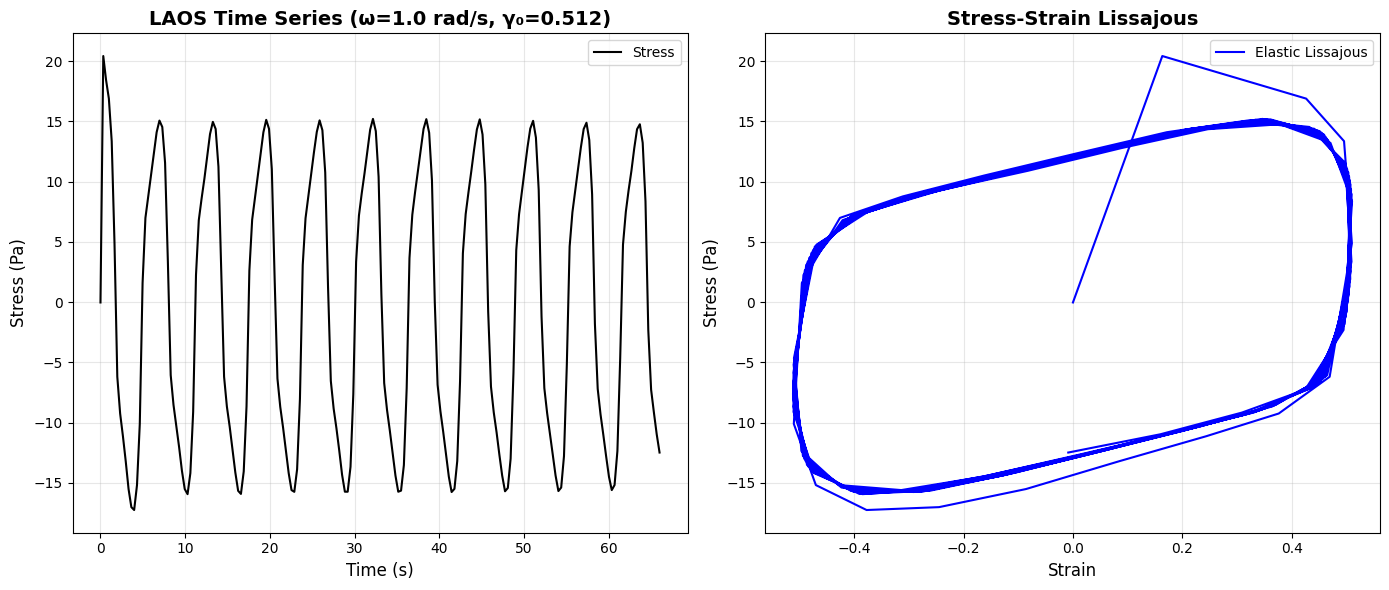

In [2]:
# Load LAOS data (ω = 1.0 rad/s, strain_amplitude_index = 5)
time_data, strain, stress = load_pnas_laos(omega=1.0, strain_amplitude_index=5)

# Extract strain amplitude
gamma_0 = float(np.max(np.abs(strain)))
omega = 1.0

print(f"Data shape: {len(time_data)} points")
print(f"Time range: {time_data.min():.2e} - {time_data.max():.2e} s")
print(f"Frequency: ω = {omega} rad/s")
print(f"Strain amplitude: γ₀ = {gamma_0:.4f}")
print(f"Max shear rate: γ̇_max = γ₀ω = {gamma_0*omega:.4f} s^-1")
print(f"Stress range: {stress.min():.2e} - {stress.max():.2e} Pa")

# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(time_data, stress, 'k-', linewidth=1.5, label='Stress')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12)
ax1.set_title(f'LAOS Time Series (ω={omega} rad/s, γ₀={gamma_0:.3f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(strain, stress, 'b-', linewidth=1.5, label='Elastic Lissajous')
ax2.set_xlabel('Strain', fontsize=12)
ax2.set_ylabel('Stress (Pa)', fontsize=12)
ax2.set_title('Stress-Strain Lissajous', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
# Initialize model
model = TNTStickyRouse(n_modes=3)
param_names = get_tnt_sticky_rouse_param_names(n_modes=3)
print(f"Model parameters ({len(param_names)}): {param_names}")

# Fit using NLSQ
print("\nFitting with NLSQ...")
start_time = time.time()
model.fit(time_data, stress, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
fit_time = time.time() - start_time

# Compute metrics
stress_pred_train = model.predict(time_data, test_mode="laos", gamma_0=gamma_0, omega=omega)
metrics_nlsq = compute_fit_quality(stress, stress_pred_train)

print(f"\nFit completed in {fit_time:.2f} seconds")
print(f"R² = {metrics_nlsq['R2']:.6f}")
print(f"RMSE = {metrics_nlsq['RMSE']:.4e} Pa")

INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=200 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


Model parameters (8): ['G_0', 'tau_R_0', 'G_1', 'tau_R_1', 'G_2', 'tau_R_2', 'tau_s', 'eta_s']

Fitting with NLSQ...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.080761s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=29 | final_cost=1.3312e+04 | elapsed=3.081s | final_gradient_norm=6.6988e-06


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=3.724309s


INFO:nlsq.curve_fit:Curve fit completed total_time=3.7243 | final_cost=2.6624e+04 | covariance_warning=False


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/sticky_rouse.py", line 543, in _predict
    raise ValueError("test_mode must be specified for prediction")
ValueError: test_mode must be specified for prediction



Fit completed in 3.89 seconds
R² = nan
RMSE = nan Pa


## Fitted Parameters

In [4]:
# Extract fitted parameters
params_nlsq = {name: model.parameters.get_value(name) for name in param_names}

print("\nFitted Parameters:")
print("-" * 50)
for name, value in params_nlsq.items():
    if 'tau' in name:
        print(f"{name:10s} = {value:12.4e} s")
    elif 'eta' in name:
        print(f"{name:10s} = {value:12.4e} Pa·s")
    else:
        print(f"{name:10s} = {value:12.4e} Pa")

# Analyze dimensionless numbers
tau_s = params_nlsq['tau_s']
print(f"\nSticker lifetime: τ_s = {tau_s:.4e} s")
print("\nMode-by-Mode Dimensionless Numbers:")
print("-" * 60)
for i in range(3):
    tau_R = params_nlsq[f'tau_R_{i}']
    tau_eff = max(tau_R, tau_s)
    De_i = omega * tau_eff
    Wi_i = gamma_0 * omega * tau_eff
    
    regime = "LINEAR" if Wi_i < 1.0 else "NONLINEAR"
    print(f"Mode {i}: De = {De_i:.3f}, Wi = {Wi_i:.3f} ({regime})")


Fitted Parameters:
--------------------------------------------------
G_0        =   1.0000e+00 Pa
tau_R_0    =   1.0001e-06 s
G_1        =   1.0030e+00 Pa
tau_R_1    =   1.0000e-06 s
G_2        =   1.0000e+00 Pa
tau_R_2    =   1.0002e-06 s
tau_s      =   1.0000e-06 s
eta_s      =   1.2968e-31 Pa·s

Sticker lifetime: τ_s = 1.0000e-06 s

Mode-by-Mode Dimensionless Numbers:
------------------------------------------------------------
Mode 0: De = 0.000, Wi = 0.000 (LINEAR)
Mode 1: De = 0.000, Wi = 0.000 (LINEAR)
Mode 2: De = 0.000, Wi = 0.000 (LINEAR)


## NLSQ Prediction vs Data

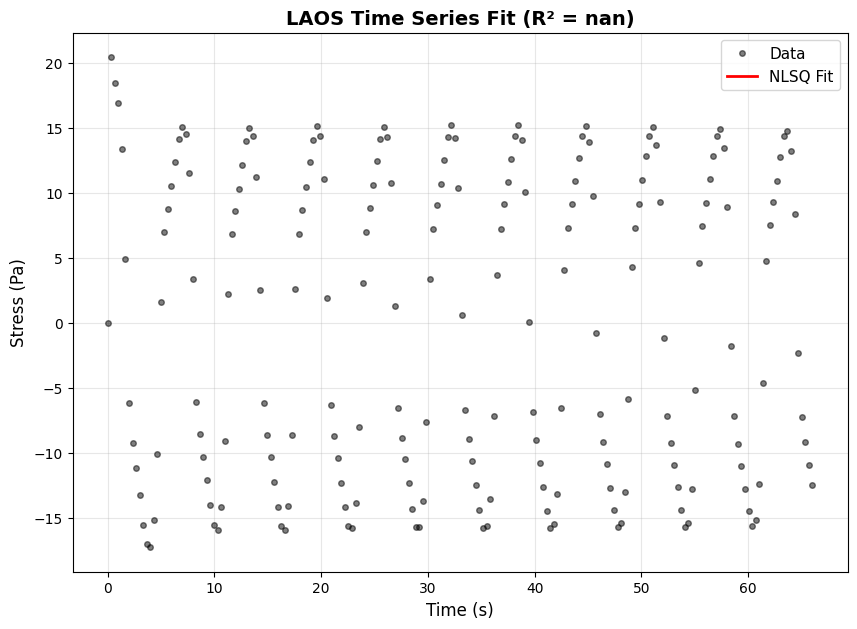

In [5]:
# Generate predictions
time_fine = np.linspace(time_data.min(), time_data.max(), 500)
stress_pred = model.predict(time_fine, test_mode="laos", gamma_0=gamma_0, omega=omega)
strain_fine = gamma_0 * np.sin(omega * time_fine)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time_data, stress, 'ko', label='Data', markersize=4, zorder=3, alpha=0.5)
ax.plot(time_fine, stress_pred, 'r-', label='NLSQ Fit', linewidth=2, zorder=2)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Stress (Pa)', fontsize=12)
ax.set_title(f'LAOS Time Series Fit (R² = {metrics_nlsq['R2']:.6f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Lissajous Curves

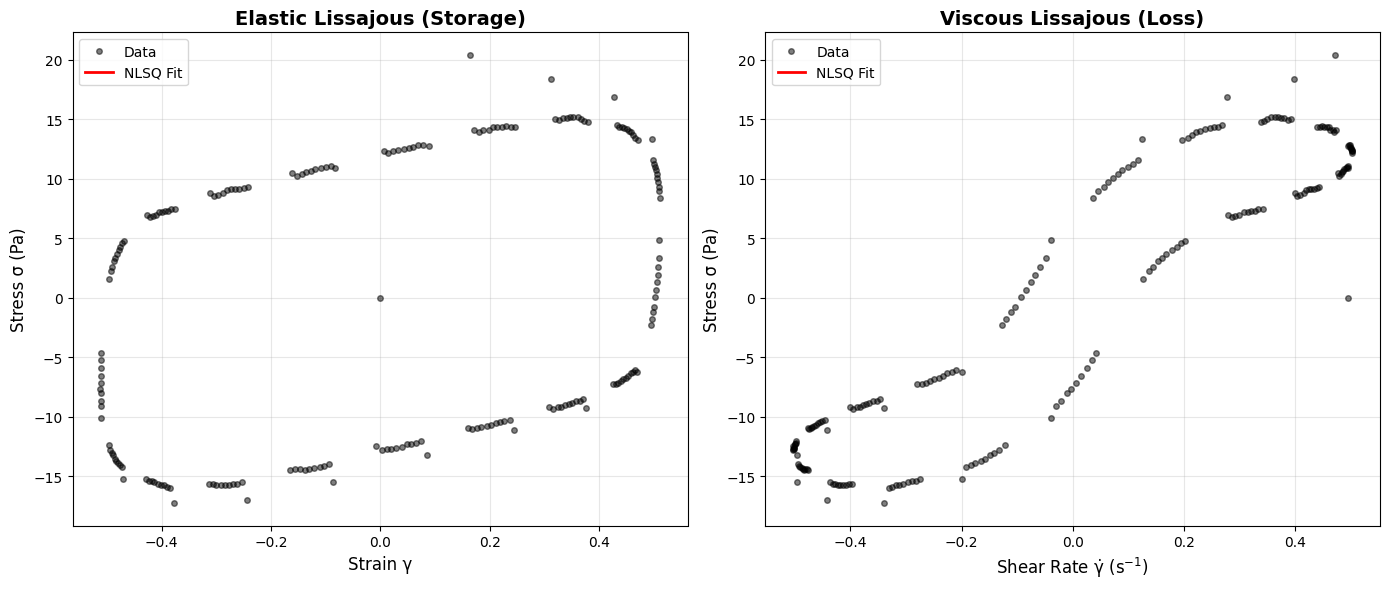

In [6]:
# Compute shear rate
gamma_dot_fine = gamma_0 * omega * np.cos(omega * time_fine)
gamma_dot_data = np.gradient(strain, time_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous (stress vs strain)
ax1.plot(strain, stress, 'ko', label='Data', markersize=4, alpha=0.5)
ax1.plot(strain_fine, stress_pred, 'r-', label='NLSQ Fit', linewidth=2)
ax1.set_xlabel('Strain γ', fontsize=12)
ax1.set_ylabel('Stress σ (Pa)', fontsize=12)
ax1.set_title('Elastic Lissajous (Storage)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Viscous Lissajous (stress vs shear rate)
ax2.plot(gamma_dot_data, stress, 'ko', label='Data', markersize=4, alpha=0.5)
ax2.plot(gamma_dot_fine, stress_pred, 'r-', label='NLSQ Fit', linewidth=2)
ax2.set_xlabel('Shear Rate γ̇ (s$^{-1}$)', fontsize=12)
ax2.set_ylabel('Stress σ (Pa)', fontsize=12)
ax2.set_title('Viscous Lissajous (Loss)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()
plt.close('all')

## FFT Harmonics Analysis

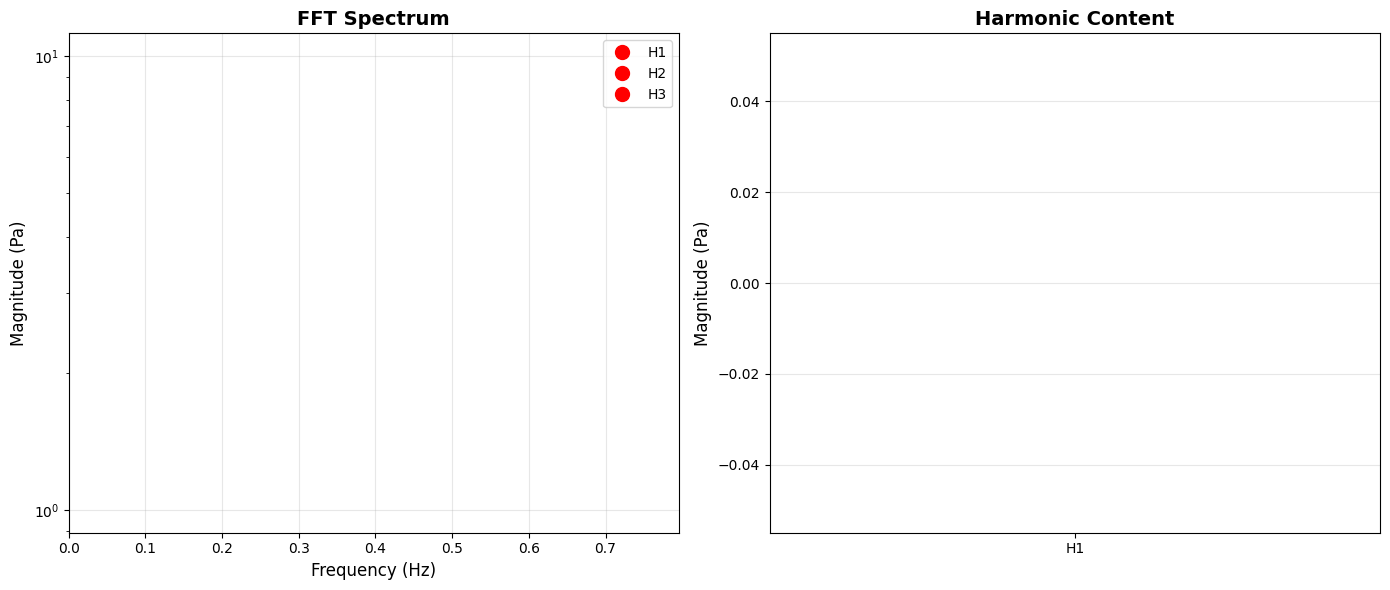


Harmonic Magnitudes:
  H1: nan Pa (nan% of fundamental)
  H2: nan Pa (nan% of fundamental)
  H3: nan Pa (nan% of fundamental)
  H4: nan Pa (nan% of fundamental)
  H5: nan Pa (nan% of fundamental)


In [7]:
# Compute FFT of stress signal
from scipy.fft import fft, fftfreq

# Use model prediction for clean FFT
dt = time_fine[1] - time_fine[0]
stress_fft = fft(stress_pred)
freqs = fftfreq(len(time_fine), dt)

# Extract positive frequencies
mask = freqs > 0
freqs_pos = freqs[mask]
stress_fft_mag = 2.0 * np.abs(stress_fft[mask]) / len(time_fine)

# Find harmonics (multiples of fundamental frequency)
f_fundamental = omega / (2.0 * np.pi)
n_harmonics = 5
harmonic_freqs = [i * f_fundamental for i in range(1, n_harmonics+1)]
harmonic_mags = []

for f_harm in harmonic_freqs:
    idx = np.argmin(np.abs(freqs_pos - f_harm))
    harmonic_mags.append(stress_fft_mag[idx])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Full spectrum
ax1.semilogy(freqs_pos, stress_fft_mag, 'b-', linewidth=1)
for i, (f, mag) in enumerate(zip(harmonic_freqs, harmonic_mags), 1):
    ax1.plot(f, mag, 'ro', markersize=10, label=f'H{i}' if i <= 3 else '')
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Magnitude (Pa)', fontsize=12)
ax1.set_title('FFT Spectrum', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 5*f_fundamental)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Harmonic bar chart
harmonic_labels = [f'H{i}' for i in range(1, n_harmonics+1)]
ax2.bar(harmonic_labels, harmonic_mags, color=['blue', 'orange', 'green', 'red', 'purple'])
ax2.set_ylabel('Magnitude (Pa)', fontsize=12)
ax2.set_title('Harmonic Content', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()
plt.close('all')

print("\nHarmonic Magnitudes:")
for i, mag in enumerate(harmonic_mags, 1):
    print(f"  H{i}: {mag:.4e} Pa ({mag/harmonic_mags[0]*100:.2f}% of fundamental)")

## Mode-Resolved Nonlinearity

In [8]:
# Analyze which modes are in nonlinear regime
tau_s = params_nlsq['tau_s']

print("Mode-Resolved Nonlinear Analysis:")
print("=" * 60)
print(f"Applied: γ₀ = {gamma_0:.4f}, ω = {omega} rad/s")
print(f"Sticker: τ_s = {tau_s:.4e} s\n")

for i in range(3):
    G_i = params_nlsq[f'G_{i}']
    tau_R_i = params_nlsq[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s)
    De_i = omega * tau_eff_i
    Wi_i = gamma_0 * omega * tau_eff_i
    
    print(f"Mode {i}:")
    print(f"  G = {G_i:.3e} Pa, τ_eff = {tau_eff_i:.3e} s")
    print(f"  De = ωτ = {De_i:.3f}")
    print(f"  Wi = γ₀ωτ = {Wi_i:.3f}")
    
    if Wi_i < 0.1:
        print(f"  ✓ DEEP LINEAR: Wi ≪ 1, mode responds linearly")
    elif Wi_i < 1.0:
        print(f"  ✓ WEAKLY NONLINEAR: Wi < 1, small nonlinear corrections")
    elif Wi_i < 10.0:
        print(f"  ✓ NONLINEAR: Wi > 1, significant nonlinear response")
    else:
        print(f"  ✓ STRONGLY NONLINEAR: Wi ≫ 1, dominant nonlinearity")
    
    if tau_s > tau_R_i:
        print(f"  (sticker-dominated)\n")
    else:
        print(f"  (Rouse-dominated)\n")

# Overall nonlinearity
Wi_max = max(gamma_0 * omega * max(params_nlsq[f'tau_R_{i}'], tau_s) for i in range(3))
print(f"Maximum Wi across modes: {Wi_max:.3f}")
if Wi_max > 1.0:
    print("System is in NONLINEAR regime (expect higher harmonics)")
else:
    print("System is in LINEAR/WEAKLY NONLINEAR regime")

Mode-Resolved Nonlinear Analysis:
Applied: γ₀ = 0.5120, ω = 1.0 rad/s
Sticker: τ_s = 1.0000e-06 s

Mode 0:
  G = 1.000e+00 Pa, τ_eff = 1.000e-06 s
  De = ωτ = 0.000
  Wi = γ₀ωτ = 0.000
  ✓ DEEP LINEAR: Wi ≪ 1, mode responds linearly
  (Rouse-dominated)

Mode 1:
  G = 1.003e+00 Pa, τ_eff = 1.000e-06 s
  De = ωτ = 0.000
  Wi = γ₀ωτ = 0.000
  ✓ DEEP LINEAR: Wi ≪ 1, mode responds linearly
  (Rouse-dominated)

Mode 2:
  G = 1.000e+00 Pa, τ_eff = 1.000e-06 s
  De = ωτ = 0.000
  Wi = γ₀ωτ = 0.000
  ✓ DEEP LINEAR: Wi ≪ 1, mode responds linearly
  (Rouse-dominated)

Maximum Wi across modes: 0.000
System is in LINEAR/WEAKLY NONLINEAR regime


## Effective Relaxation Time Analysis

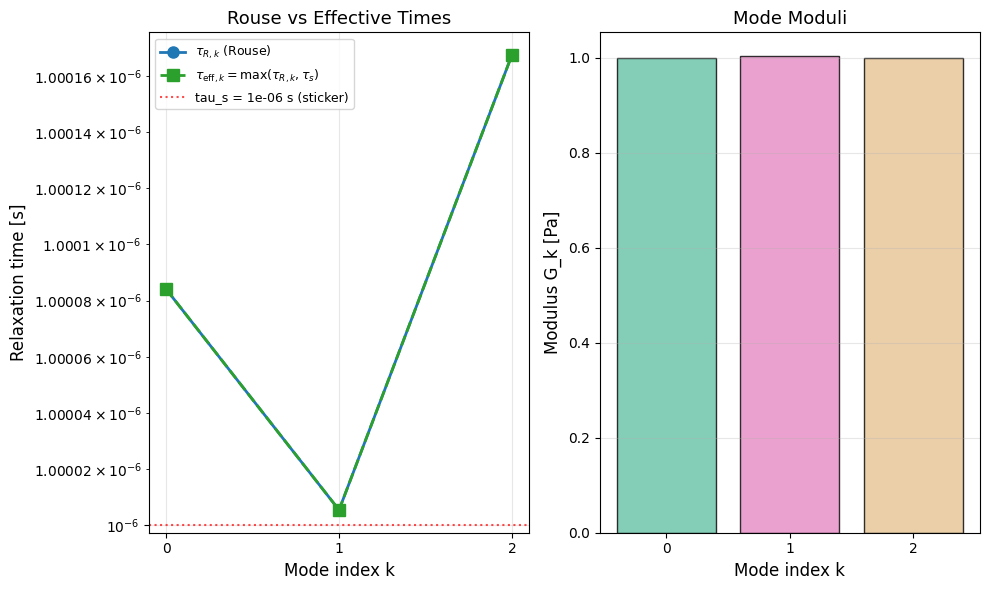

In [9]:
# Visualize sticker-mode interaction
fig = plot_sticky_rouse_effective_times(model)
plt.show()
plt.close('all')

## Bayesian Inference

In [10]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    result_bayes = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    result_bayes = model.fit_bayesian(
        time_data, stress,
        test_mode='laos',
        
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


## Convergence Diagnostics

In [11]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(result_bayes, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


## Parameter Comparison: NLSQ vs Bayesian

In [12]:
# Compare point estimates
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0             1             1  [1, 1]
        tau_R_0         1e-06         1e-06  [1e-06, 1e-06]
            G_1         1.003         1.003  [1.003, 1.003]
        tau_R_1         1e-06         1e-06  [1e-06, 1e-06]
            G_2             1             1  [1, 1]
        tau_R_2         1e-06         1e-06  [1e-06, 1e-06]
          tau_s         1e-06         1e-06  [1e-06, 1e-06]
          eta_s     1.297e-31     1.297e-31  [1.297e-31, 1.297e-31]


## ArviZ: Trace Plot

In [13]:
# Skip trace plot in CI mode
if not CI_MODE:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})
    
    # Trace plot
    axes = az.plot_trace(idata, compact=False, figsize=(12, 2*len(param_names)))
    fig = axes.ravel()[0].figure
    fig.suptitle('MCMC Trace Plot', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


## ArviZ: Posterior Distributions

In [14]:
# Skip ArviZ plot in CI mode
if not CI_MODE:
    # Posterior plot
    axes = az.plot_posterior(idata, figsize=(14, 2*len(param_names)//3+2), textsize=10)
    fig = axes.ravel()[0].figure
    fig.suptitle('Posterior Distributions (95% HDI)', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping ArviZ plot")


CI_MODE: Skipping ArviZ plot


## ArviZ: Pair Plot

In [15]:
# Skip pair plot in CI mode
if not CI_MODE:
    # Pair plot for correlations
    key_params = ['G_0', 'tau_R_0', 'tau_s', 'eta_s']
    axes = az.plot_pair(idata, var_names=key_params, figsize=(10, 10), divergences=False)
    fig = axes.ravel()[0].figure
    fig.suptitle('Parameter Correlations (Key Parameters)', fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


## Posterior Predictive Distribution

In [ ]:
# CI mode: Skip slow posterior predictive (200 ODE solves)
if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 predictions would take >300s)")
    # Use NLSQ fit for visualization instead
    pred_mean = model.predict(time_fine, test_mode="laos", gamma_0=gamma_0, omega=omega)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time_data, stress, 'ko', label='Data', markersize=4, alpha=0.5, zorder=3)
    ax.plot(time_fine, pred_mean, 'b-', label='NLSQ Fit', linewidth=2, zorder=2)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Stress (Pa)', fontsize=12)
    ax.set_title('LAOS (CI Mode)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')
else:
    # Generate predictions from posterior samples
    posterior = result_bayes.posterior_samples
    n_draws = min(200, NUM_SAMPLES)
    indices = np.linspace(0, NUM_SAMPLES-1, n_draws, dtype=int)

    predictions = []
    for i in indices:
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        pred_i = model.predict(time_fine, test_mode="laos", gamma_0=gamma_0, omega=omega)
        predictions.append(np.array(pred_i))

    predictions = np.array(predictions)
    pred_mean = np.mean(predictions, axis=0)
    pred_lower = np.percentile(predictions, 2.5, axis=0)
    pred_upper = np.percentile(predictions, 97.5, axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time_data, stress, 'ko', label='Data', markersize=4, alpha=0.5, zorder=3)
    ax.plot(time_fine, pred_mean, 'b-', label='Posterior Mean', linewidth=2, zorder=2)
    ax.fill_between(time_fine, pred_lower, pred_upper, alpha=0.3, color='blue', label='95% Credible Interval')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Stress (Pa)', fontsize=12)
    ax.set_title('Posterior Predictive Distribution', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')

## Physical Interpretation

In [ ]:
# Get posterior samples (defined in CI_MODE or from Bayesian result)
posterior = result_bayes.posterior_samples

# Extract posterior means
params_bayes = {name: float(np.mean(posterior[name])) for name in param_names}
tau_s_bayes = params_bayes['tau_s']

print("Physical Interpretation (Posterior Means):")
print("=" * 60)
print(f"\nLAOS Conditions:")
print(f"  Frequency: ω = {omega} rad/s")
print(f"  Strain amplitude: γ₀ = {gamma_0:.4f}")
print(f"  Max shear rate: γ̇_max = {gamma_0*omega:.4f} s^-1")
print(f"\nSticker Lifetime: τ_s = {tau_s_bayes:.4e} s")

print("\nMode-by-Mode LAOS Response:")
print("-" * 60)
for i in range(3):
    G_i = params_bayes[f'G_{i}']
    tau_R_i = params_bayes[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s_bayes)
    De_i = omega * tau_eff_i
    Wi_i = gamma_0 * omega * tau_eff_i
    
    print(f"\nMode {i}:")
    print(f"  Modulus: G_{i} = {G_i:.4e} Pa")
    print(f"  Effective time: τ_eff = {tau_eff_i:.4e} s")
    print(f"  Deborah number: De = ωτ = {De_i:.3f}")
    print(f"  Weissenberg number: Wi = γ₀ωτ = {Wi_i:.3f}")
    
    if tau_s_bayes > tau_R_i:
        print(f"  ✓ STICKER-DOMINATED: Collective nonlinear onset at Wi_s = {gamma_0*omega*tau_s_bayes:.3f}")
    else:
        print(f"  ✓ ROUSE: Independent nonlinear threshold at Wi = {Wi_i:.3f}")
    
    if Wi_i > 1.0:
        print(f"  → NONLINEAR: Contributes to higher harmonics")
    else:
        print(f"  → LINEAR: Fundamental harmonic only")

# Collective nonlinearity analysis
n_sticker_modes = sum(1 for i in range(3) if params_bayes[f'tau_R_{i}'] < tau_s_bayes)
Wi_sticker = gamma_0 * omega * tau_s_bayes

print(f"\nCollective Nonlinearity:")
print(f"  Sticker-dominated modes: {n_sticker_modes}/3")
print(f"  Collective Wi: {Wi_sticker:.3f}")
if n_sticker_modes > 1:
    print(f"  → {n_sticker_modes} modes enter nonlinear regime together")

# Overall system response
Wi_max = max(gamma_0 * omega * max(params_bayes[f'tau_R_{i}'], tau_s_bayes) for i in range(3))
print(f"\nSystem-Level Response:")
print(f"  Maximum Wi: {Wi_max:.3f}")
if Wi_max > 1.0:
    print(f"  ✓ NONLINEAR REGIME: Expect significant higher harmonics")
else:
    print(f"  ✓ LINEAR/WEAKLY NONLINEAR: Fundamental harmonic dominates")

## Save Results

In [18]:
# Save results to disk
output_path = save_tnt_results(model, result_bayes, "sticky_rouse", "laos", param_names)
print(f"Results saved to: {output_path}")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/sticky_rouse/laos/
  nlsq_params_laos.json: 8 parameters
  posterior_laos.json: 500 draws
Results saved to: None


## Key Takeaways

1. **Mode-Resolved Nonlinearity**: Each mode has distinct Weissenberg number Wi_k = γ₀ω τ_eff,k → sequential nonlinear onset

2. **Collective Response**: Sticker-dominated modes (τ_R,k < τ_s) all have Wi based on τ_s → enter nonlinearity together

3. **Lissajous Curves**: Elastic (stress-strain) and viscous (stress-strain rate) Lissajous reveal nonlinear character

4. **Harmonics**: FFT decomposition quantifies nonlinearity strength via higher harmonic ratios

5. **Dimensionless Numbers**:
   - De = ωτ: Frequency vs relaxation (oscillation regime)
   - Wi = γ₀ωτ: Deformation rate vs relaxation (nonlinearity onset)

6. **Design Insight**: To isolate mode k, choose ω ~ 1/τ_eff,k and vary γ₀ to scan Wi_k across linear-to-nonlinear transition